In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib.patches import Rectangle, Circle, Patch
from matplotlib.lines import Line2D

## Load onboard data

In [2]:
file_path = "/home/nithish/autoware/src/universe/autoware.universe/perception/sim_c_v2i_evaluation/data/onboard_objects/onboard_objects.csv"
onboard_df = pd.read_csv(file_path, names=["obj1_px", "obj1_py", "obj1_pz", "obj1_qx", "obj1_qy", "obj1_qz", "obj1_qw", "obj1_dim_x", "obj1_dim_y", "obj1_dim_z",\
                                              "obj2_px", "obj2_py", "obj2_pz", "obj2_qx", "obj2_qy", "obj2_qz", "obj2_qw", "obj2_dim_x", "obj2_dim_y", "obj2_dim_z"])
onboard_df.index.name = "frame_id"

In [3]:
onboard_df.head(2)

,obj1_px,obj1_py,obj1_pz,obj1_qx,obj1_qy,obj1_qz,obj1_qw,obj1_dim_x,obj1_dim_y,obj1_dim_z,obj2_px,obj2_py,obj2_pz,obj2_qx,obj2_qy,obj2_qz,obj2_qw,obj2_dim_x,obj2_dim_y,obj2_dim_z
frame_id,,,,,,,,,,,,,,,,,,,,
0,-28.419691,-10.689223,1.331055,0.0,0.0,0.693138,0.720805,4.234899,1.914419,1.920974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-28.398441,-11.075942,1.308594,0.0,-0.0,-0.767616,-0.640909,4.297390,1.915354,1.881061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Compute euclidean distance between adversary and ego vehicle on first detection (onboard sensor alone)

In [4]:
eu_dist_btw_adversary_and_ego = (onboard_df.iloc[154,10]**2 + onboard_df.iloc[154,11]**2)**0.5

In [5]:
print(f"Euclidean distance between adverary and ego vehicle on first detection with onboard sensor alone: {eu_dist_btw_adversary_and_ego:.2f} m")

Euclidean distance between adverary and ego vehicle on first detection with onboard sensor alone: 21.60 m


## Load Merged data

In [6]:
file_path = "/home/nithish/autoware/src/universe/autoware.universe/perception/sim_c_v2i_evaluation/data/merged_objects/merged_objects.csv"
merged_df = pd.read_csv(file_path, names=["obj1_px", "obj1_py", "obj1_pz", "obj1_qx", "obj1_qy", "obj1_qz", "obj1_qw", "obj1_dim_x", "obj1_dim_y", "obj1_dim_z",\
                                              "obj2_px", "obj2_py", "obj2_pz", "obj2_qx", "obj2_qy", "obj2_qz", "obj2_qw", "obj2_dim_x", "obj2_dim_y", "obj2_dim_z"])
merged_df.index.name = "frame_id"

#### Compute euclidean distance between adversary and ego vehicle on first detection (Infrastructure fusion)

In [8]:
merged_df.iloc[56,10]

66.92195920471141

In [7]:
eu_dist_btw_adversary_and_ego = (merged_df.iloc[56,10]**2 + merged_df.iloc[56,11]**2)**0.5

In [8]:
print(f"Euclidean distance between adverary and ego vehicle on first detection with infrastructure fusion: {eu_dist_btw_adversary_and_ego:.2f} m")

Euclidean distance between adverary and ego vehicle on first detection with infrastructure fusion: 76.02 m


## Plot to convey the benefit

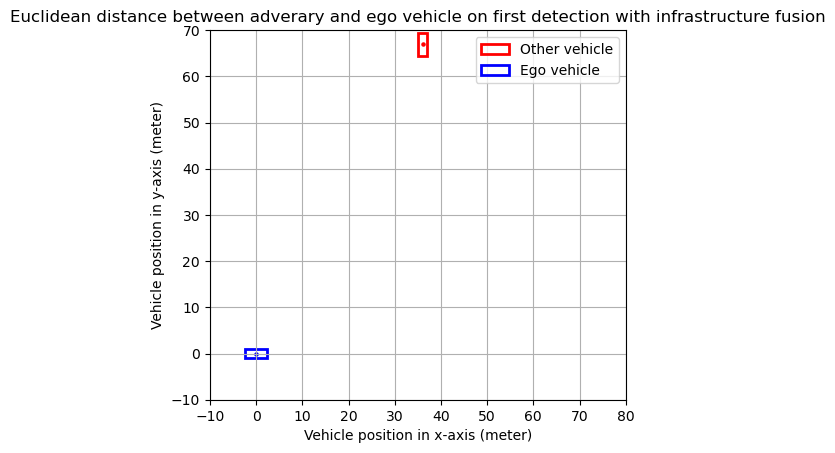

In [18]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely.affinity import rotate
from matplotlib.patches import Polygon as MplPolygon

def create_rotated_box(center_x, center_y, width, height, angle):
    half_width = width / 2
    half_height = height / 2
    rectangle = Polygon([
        (center_x - half_width, center_y - half_height),
        (center_x + half_width, center_y - half_height),
        (center_x + half_width, center_y + half_height),
        (center_x - half_width, center_y + half_height)
    ])
    rotated_rectangle = rotate(rectangle, angle, origin='center', use_radians=False)
    return rotated_rectangle

def calculate_iou(box1, box2):
    intersection = box1.intersection(box2).area
    union = box1.union(box2).area
    return intersection / union if union > 0 else 0

def plot_boxes(box1, box2, point1, point2):
    fig, ax = plt.subplots()
    
    # Convert shapely Polygons to matplotlib Polygons for visualization
    mpl_box1 = MplPolygon(list(box1.exterior.coords), edgecolor='red', facecolor='none', linewidth=2, label='Other vehicle')
    mpl_box2 = MplPolygon(list(box2.exterior.coords), edgecolor='blue', facecolor='none', linewidth=2, label='Ego vehicle')

    ax.add_patch(mpl_box1)
    ax.add_patch(mpl_box2)

    ax.scatter(point1[0], point1[1], color='red', s=5, label='_nolegend_')
    ax.scatter(point2[0], point2[1], color='blue', s=5, label='_nolegend_')

    # Plot the boxes
    ax.set_xlim(-10, 80)
    ax.set_ylim(-10, 70)
    ax.set_aspect('equal', 'box')
    plt.legend()
    plt.title("Euclidean distance between adverary and ego vehicle on first detection with infrastructure fusion")
    plt.xlabel("Vehicle position in x-axis (meter)")
    plt.ylabel("Vehicle position in y-axis (meter)")
    plt.grid(True)
    plt.show()
    fig.savefig("distance_between_vehicles_with_infrastructure_fusion.png", dpi=300, bbox_inches='tight')

# Example parameters for two rotated boxes
center_x1, center_y1, width1, height1, angle1 = merged_df.iloc[56,11], merged_df.iloc[56,10], merged_df.iloc[56,17], merged_df.iloc[56,18], 90
center_x2, center_y2, width2, height2, angle2 = 0.0, 0.0, 4.67, 1.81, 0

# Create the rotated boxes
box1 = create_rotated_box(center_x1, center_y1, width1, height1, angle1)
box2 = create_rotated_box(center_x2, center_y2, width2, height2, angle2)
point1 = [merged_df.iloc[56,11], merged_df.iloc[56,10]]
point2 = [0.0, 0.0]

# Visualize the boxes
plot_boxes(box1, box2, point1, point2)

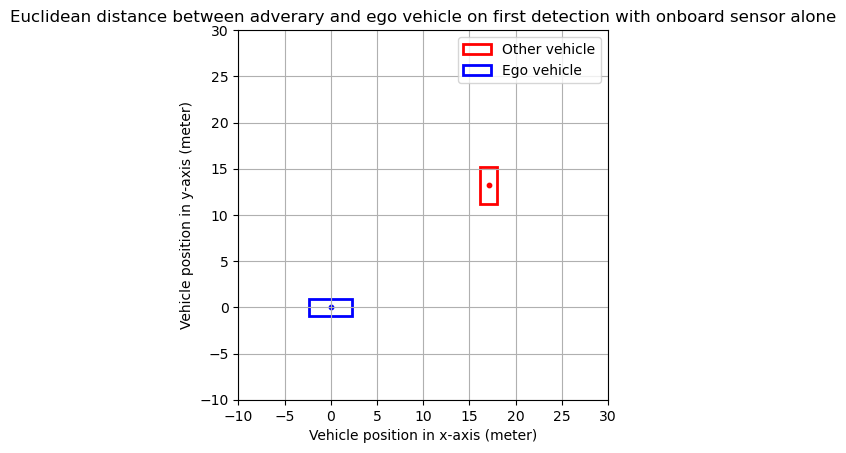

In [20]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely.affinity import rotate
from matplotlib.patches import Polygon as MplPolygon

def create_rotated_box(center_x, center_y, width, height, angle):
    half_width = width / 2
    half_height = height / 2
    rectangle = Polygon([
        (center_x - half_width, center_y - half_height),
        (center_x + half_width, center_y - half_height),
        (center_x + half_width, center_y + half_height),
        (center_x - half_width, center_y + half_height)
    ])
    rotated_rectangle = rotate(rectangle, angle, origin='center', use_radians=False)
    return rotated_rectangle

def calculate_iou(box1, box2):
    intersection = box1.intersection(box2).area
    union = box1.union(box2).area
    return intersection / union if union > 0 else 0

def plot_boxes(box1, box2, point1, point2):
    fig, ax = plt.subplots()
    
    # Convert shapely Polygons to matplotlib Polygons for visualization
    mpl_box1 = MplPolygon(list(box1.exterior.coords), edgecolor='red', facecolor='none', linewidth=2, label='Other vehicle')
    mpl_box2 = MplPolygon(list(box2.exterior.coords), edgecolor='blue', facecolor='none', linewidth=2, label='Ego vehicle')

    ax.add_patch(mpl_box1)
    ax.add_patch(mpl_box2)

    ax.scatter(point1[0], point1[1], color='red', s=10, label='_nolegend_')
    ax.scatter(point2[0], point2[1], color='blue', s=10, label='_nolegend_')

    # Plot the boxes
    ax.set_xlim(-10, 30)
    ax.set_ylim(-10, 30)
    ax.set_aspect('equal', 'box')
    plt.legend()
    plt.title("Euclidean distance between adverary and ego vehicle on first detection with onboard sensor alone")
    plt.xlabel("Vehicle position in x-axis (meter)")
    plt.ylabel("Vehicle position in y-axis (meter)")
    plt.grid(True)
    plt.show()
    fig.savefig("distance_between_vehicles_with_onboard_alone.png", dpi=300, bbox_inches='tight')

# Example parameters for two rotated boxes
center_x1, center_y1, width1, height1, angle1 = onboard_df.iloc[154,11], onboard_df.iloc[154,10], onboard_df.iloc[154,17], onboard_df.iloc[154,18], 90
center_x2, center_y2, width2, height2, angle2 = 0.0, 0.0, 4.67, 1.81, 0

# Create the rotated boxes
box1 = create_rotated_box(center_x1, center_y1, width1, height1, angle1)
box2 = create_rotated_box(center_x2, center_y2, width2, height2, angle2)
point1 = [onboard_df.iloc[154,11], onboard_df.iloc[154,10]]
point2 = [0.0, 0.0]

# Visualize the boxes
plot_boxes(box1, box2, point1, point2)